# Challenge

1. Find the year with the highest mean TMAX in Minneapolis
2. Find the year with the lowest mean TLOW in San Diego
3. Plot those two years on the same graph

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
def parsedata(data, delimiters, columns, dtype, names):
    return np.genfromtxt(data, 
                         delimiter=delimiters,
                         usecols=columns,
                         dtype=dtype,
                         names=names)

In [3]:
delimiters = [11, 4, 2, 4] + [5, 1, 1, 1] * 31

In [6]:
delimiters[:20]

[11, 4, 2, 4, 5, 1, 1, 1, 5, 1, 1, 1, 5, 1, 1, 1, 5, 1, 1, 1]

In [7]:
# Don't want column 0, and every 4th column after column 4
columns = [1, 2, 3] + [4*i for i in range(1, 32)]

In [8]:
columns

[1,
 2,
 3,
 4,
 8,
 12,
 16,
 20,
 24,
 28,
 32,
 36,
 40,
 44,
 48,
 52,
 56,
 60,
 64,
 68,
 72,
 76,
 80,
 84,
 88,
 92,
 96,
 100,
 104,
 108,
 112,
 116,
 120,
 124]

In [9]:
names = ['year', 'month', 'obs'] + [str(day) for day in range(1, 31+1)]

In [11]:
names[:10]

['year', 'month', 'obs', '1', '2', '3', '4', '5', '6', '7']

In [12]:
dtypes = [np.int32, np.int32, (np.str_, 4)] + [np.int32] * 31

In [13]:
sandiego = parsedata('sandiego.dly', delimiters, columns, dtypes, names)

In [14]:
minneapolis = parsedata('minneapolis.dly', delimiters, columns, dtypes, names)

In [47]:
sandiego[1]

(1939, 7, 'TMIN', 172, 183, 167, 172, 178, 183, 161, 172, 183, 183, 172, 178, 172, 167, 156, 150, 156, 167, 156, 189, 172, 178, 178, 183, 194, 178, 178, 172, 183, 183, 189)

Again, the temperatures are all in the same row, which may actually work in this case. We want to extract just the year.

In [60]:
# unroll takes the year and month from the record, which is fed in a row at a time. 
# It creates a range of dates, starting at the first of the month, ending at the end of the month.
# Each row is an array of tuples containing the date and the temperature on that date.
# The dtypes are assigned to complete the record array.

def unroll(record):
    startdate = np.datetime64('{}-{:02}'.format(record['year'], record['month']))
    dates = np.arange(startdate, startdate + np.timedelta64(1, 'M'), np.timedelta64(1, 'D'))
    
    rows = [(date, record[str(i+1)]/10) for i, date in enumerate(dates)]
    return np.array(rows, dtype=[('date', 'M8[D]'), ('value', 'd')])

In [157]:
unroll(sandiego[1])

array([('1939-07-01', 17.2), ('1939-07-02', 18.3), ('1939-07-03', 16.7),
       ('1939-07-04', 17.2), ('1939-07-05', 17.8), ('1939-07-06', 18.3),
       ('1939-07-07', 16.1), ('1939-07-08', 17.2), ('1939-07-09', 18.3),
       ('1939-07-10', 18.3), ('1939-07-11', 17.2), ('1939-07-12', 17.8),
       ('1939-07-13', 17.2), ('1939-07-14', 16.7), ('1939-07-15', 15.6),
       ('1939-07-16', 15. ), ('1939-07-17', 15.6), ('1939-07-18', 16.7),
       ('1939-07-19', 15.6), ('1939-07-20', 18.9), ('1939-07-21', 17.2),
       ('1939-07-22', 17.8), ('1939-07-23', 17.8), ('1939-07-24', 18.3),
       ('1939-07-25', 19.4), ('1939-07-26', 17.8), ('1939-07-27', 17.8),
       ('1939-07-28', 17.2), ('1939-07-29', 18.3), ('1939-07-30', 18.3),
       ('1939-07-31', 18.9)], dtype=[('date', '<M8[D]'), ('value', '<f8')])

In [142]:
# dtypes:
d = np.datetime64('2019-10-25')
d.dtype

dtype('<M8[D]')

In [143]:
d = np.datetime64('2019-01')
d.dtype

dtype('<M8[M]')

In [144]:
d = np.datetime64('2019')
d.dtype

dtype('<M8[Y]')

In [148]:
y = np.array([1967], dtype='d')
y.dtype

dtype('float64')

Again, _unroll_ only handles one row at a time, so we need another function to hand it rows and concatenate the results.

In [113]:
def getobs(filename, obs):
    return np.concatenate([unroll(row) for row in filename if row[2] == obs])

One row at a time is fed into the unroll function, and they are concatenated into a single row. Only those observations corresponding to 'obs' are selected.

In [159]:
sd_tmin = getobs(sandiego, 'TMIN')
min_tmax = getobs(minneapolis, 'TMAX')
min_tmin = getobs(minneapolis, 'TMIN')
sd_tmax = getobs(sandiego, 'TMAX')

In [160]:
sd_tmax.shape

(29525,)

In [84]:
sd_tmin['value'][sd_tmin['value'] == -999.9] = np.nan
sd_tmax['value'][sd_tmax['value'] == -999.9] = np.nan

In [85]:
sd_tmin

array([('1939-07-01', 17.2), ('1939-07-02', 18.3), ('1939-07-03', 16.7),
       ..., ('2020-04-28',  nan), ('2020-04-29',  nan),
       ('2020-04-30',  nan)], dtype=[('date', '<M8[D]'), ('value', '<f8')])

We again have some missing data, and filled it in with nan.

In [115]:
min_tmax['value'][min_tmax['value'] == -999.9] = np.nan
min_tmin['value'][min_tmin['value'] == -999.9] = np.nan

In [116]:
def fillnans(data):
    date_float = data['date'].astype(np.float32)
    nan = np.isnan(data['value'])
    data['value'][nan] = np.interp(date_float[nan], date_float[~nan], data['value'][~nan])

In [117]:
fillnans(sd_tmin)
fillnans(min_tmax)
fillnans(min_tmin)
fillnans(sd_tmax)

In [96]:
def selectyear(data, year):
    start = np.datetime64('{}'.format(year))
    end = start + np.timedelta64(1, 'Y')
    
    return data[(data['date'] >= start) & (data['date'] < end)]['value']

Let's pick a year range that works for both datasets.

In [102]:
sd_tmin['date'][0]

numpy.datetime64('1939-07-01')

In [103]:
min_tmax['date'][0]

numpy.datetime64('1938-04-01')

We'll select 1940 as the start year.

In [104]:
sd_tmin['date'][-1]

numpy.datetime64('2020-04-30')

In [105]:
min_tmax['date'][-1]

numpy.datetime64('2020-04-30')

We'll select 2019 at the end year.

In [106]:
years = np.arange(1940, 2019+1)

In [109]:
min_tmax_all = np.vstack([selectyear(min_tmax, year)[:365] for year in years])

In [110]:
sd_tmin_all = np.vstack([selectyear(sd_tmin, year)[:365] for year in years])

In [118]:
min_mean = np.mean(min_tmax_all, axis=1)

In [119]:
min_mean

array([11.83917808, 13.82547945, 12.75561644, 11.87452055, 13.12520548,
       11.6430137 , 13.43260274, 12.54328767, 13.36410959, 13.54219178,
       10.8569863 , 10.44876712, 12.80109589, 13.64356164, 12.78493151,
       12.96191781, 12.65589041, 12.49863014, 13.10438356, 12.94986301,
       12.18849315, 12.48767123, 11.22136986, 12.85616438, 13.30027397,
       11.0890411 , 11.89205479, 11.47780822, 12.64821918, 12.27178082,
       12.07945205, 12.01835616, 10.28465753, 13.11643836, 12.26849315,
       12.26465753, 13.88438356, 12.65945205, 12.21123288, 11.47726027,
       12.87780822, 13.33589041, 12.05726027, 12.1709589 , 12.2860274 ,
       11.75835616, 12.51917808, 15.14986301, 13.84164384, 12.12493151,
       14.04356164, 12.83013699, 12.28273973, 11.29589041, 12.78767123,
       12.55753425, 11.15534247, 12.08328767, 14.54383562, 14.02438356,
       12.90739726, 13.54109589, 12.88109589, 12.93671233, 12.8539726 ,
       13.77972603, 14.43068493, 13.70465753, 12.10739726, 12.33

In [120]:
sd_mean = np.mean(sd_tmin_all, axis=1)

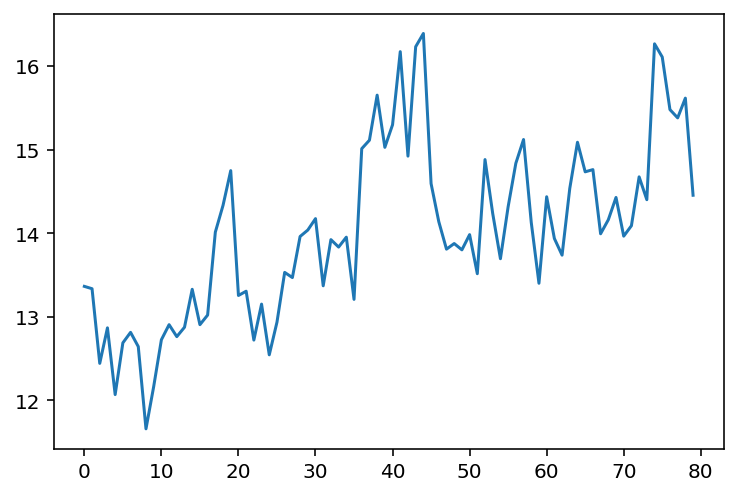

In [121]:
plt.plot(sd_mean)

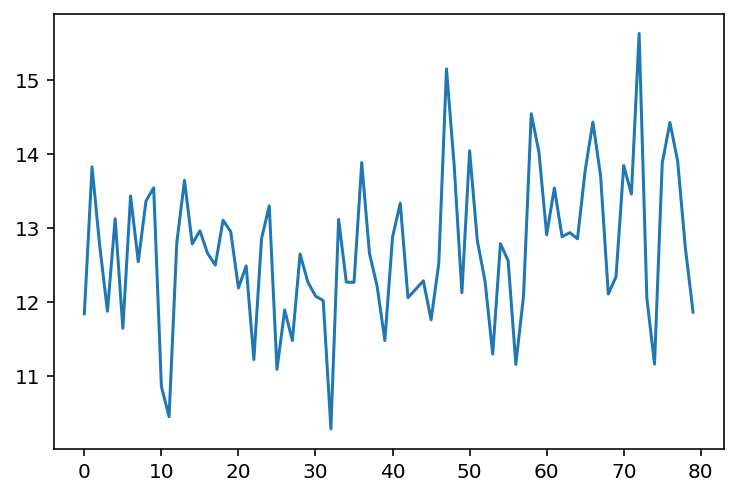

In [122]:
plt.plot(min_mean)

Time to get the maximum and minimum years.

In [123]:
sd_coldest = years[np.argmin(sd_mean)]
sd_coldest

1948

In [124]:
min_warmest = years[np.argmax(min_mean)]
min_warmest

2012

(-17.25, 366.0, -27.04, 42.04)

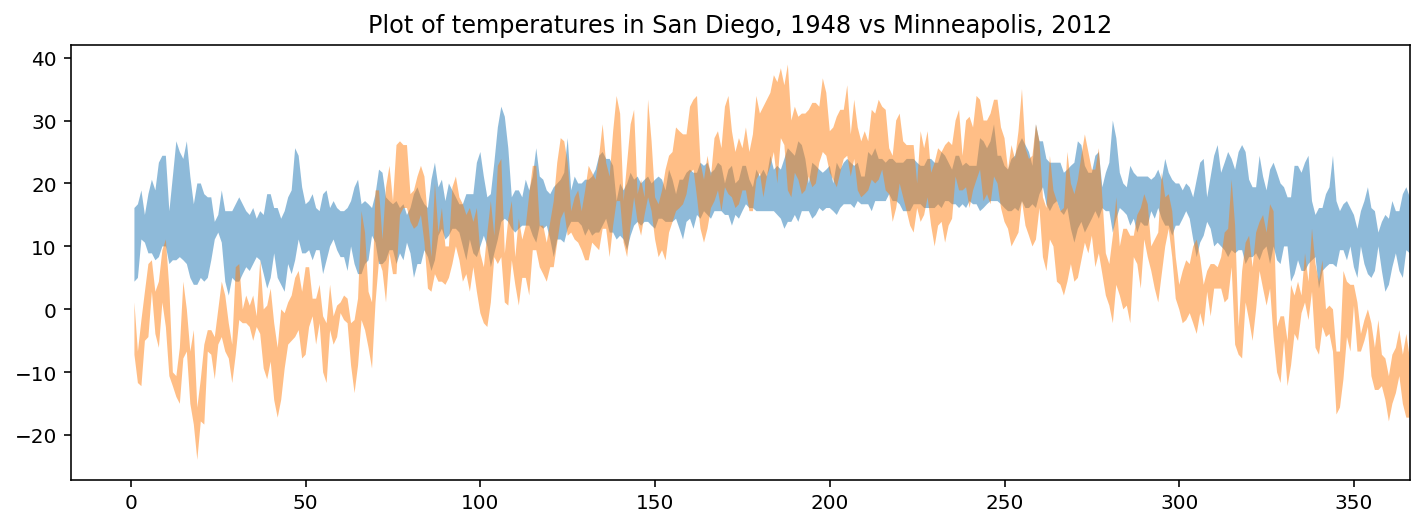

In [134]:
days = np.arange(1, 366+1)
plt.figure(figsize=(12, 4))
plt.title(f'Plot of temperatures in San Diego, {sd_coldest} vs Minneapolis, {min_warmest}')
plt.fill_between(days, selectyear(sd_tmin, 1948), selectyear(sd_tmax, 1948), alpha=0.5)
plt.fill_between(days, selectyear(min_tmin, 2012), selectyear(min_tmax, 2012), alpha=0.5)
plt.axis(xmax=366)

In [163]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
np.concatenate((a, b), axis=0)

array([1, 2, 3, 4, 5, 6])